In this notebook, we can test the performance of a previously trained GrappaNet model on test images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft 
from utils import apply_kernel_weight, estimate_mdgrappa_kernel
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import add, Dropout, Lambda, ReLU
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow_addons as tfa
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

crop_size = (32,640,320)


lamda = 0.001


@tf.function
def model_loss_ssim(y_true, y_pred):
    global lamda
    ssim_loss = 0
    max_val = 1.0
    if tf.reduce_max(y_pred)>1.0:
        max_val = tf.reduce_max(y_pred)
    ssim_loss = tf.math.abs(tf.reduce_mean(tf.image.ssim(img1=y_true,img2=y_pred,max_val=max_val,filter_size=3,filter_sigma=0.1)))
    l1_loss = lamda*tf.reduce_mean(tf.math.abs(y_true-y_pred))
    return 1-ssim_loss+l1_loss


def conv_block(ip, nfilters, drop_rate):
    
    layer_top = Conv2D(nfilters,(3,3),padding="same")(ip)

    #layer_top = BatchNormalization()(layer_top)
    layer_top = tfa.layers.InstanceNormalization(axis=3,center=True, 
                                                 scale=True,beta_initializer="random_uniform",
                                                 gamma_initializer="random_uniform")(layer_top)
    res_model = ReLU()(layer_top)
    res_model = Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters,(3,3),padding="same")(res_model)
    res_model = tfa.layers.InstanceNormalization(axis=3, center=True, 
                                                 scale=True,beta_initializer="random_uniform",
                                                 gamma_initializer="random_uniform")(res_model)
    #res_model = BatchNormalization()(res_model)
    res_model = Dropout(drop_rate)(res_model)
    res_model = add([layer_top,res_model])
    res_model = ReLU()(res_model)
    return res_model


def encoder(inp,nlayers, nbasefilters, drop_rate):
    
    skip_layers = []
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*2**i,drop_rate)
        skip_layers.append(layers)
        layers = MaxPooling2D((2,2))(layers)
    return layers, skip_layers


def decoder(inp,nlayers, nbasefilters, skip_layers, drop_rate):
    
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        layers = UpSampling2D(size=(2,2),interpolation='bilinear')(layers)
        layers = add([layers,skip_layers.pop()])
    return layers


def create_gen(gen_ip, nlayers, nbasefilters, drop_rate):
    op,skip_layers = encoder(gen_ip,nlayers,nbasefilters,drop_rate)
    op = decoder(op,nlayers,nbasefilters,skip_layers,drop_rate)
    op = Conv2D(crop_size[0],(3,3),padding="same")(op)
    return op


def custom_data_consistency(tensors):
    output = tf.where(tf.greater_equal(tensors[0], 1), tensors[0], tensors[1])
    out_cmplx = tf.complex(output[:,:,:,0:(crop_size[0]//2)], output[:,:,:,(crop_size[0]//2):(crop_size[0])])
    ift_sig = tf.signal.fftshift(tf.signal.ifft2d(out_cmplx, name=None))
    real_p = tf.math.real(ift_sig)
    imag_p = tf.math.imag(ift_sig)
    comb = tf.concat(axis=-1,values=[real_p, imag_p])
    return comb


def custom_data_consistency_2(tensors):
    out_cmplx = tf.complex(tensors[1][:,:,:,0:(crop_size[0]//2)], tensors[1][:,:,:,(crop_size[0]//2):(crop_size[0])])
    ft_sig = tf.signal.fftshift(tf.signal.fft2d(out_cmplx, name=None))
    real_p = tf.math.real(ft_sig)
    imag_p = tf.math.imag(ft_sig)
    comb = tf.concat(axis=-1,values=[real_p, imag_p])
    output = tf.where(tf.greater_equal(tensors[0], 1), tensors[0], comb)
    return output


def aux_Grappa_layer(tensor1, tensor2):
    global grappa_wt
    global grappa_p
    t1 = tensor1.numpy()
    t2 = tensor2.numpy()

    x_train_cmplx_target = t2[:,:,:,0:(crop_size[0]//2)]+1j*t2[:,:,:,(crop_size[0]//2):(crop_size[0])]
    x_train_cmplx_target = np.transpose(x_train_cmplx_target,(0,3,1,2))
    l_grappa = []
    for i in range(x_train_cmplx_target.shape[0]):
        res = apply_kernel_weight(kspace=x_train_cmplx_target[i],calib=None,
                                 kernel_size=(5,5),coil_axis=0,
                                 weights=grappa_wt[int(t1[i][0])],P=grappa_p[int(t1[i][0])])
        res = np.transpose(res,(1,2,0))
        out_cmplx_real = tf.convert_to_tensor(res.real)
        out_cmplx_imag = tf.convert_to_tensor(res.imag)
        comb = tf.concat(axis=2,values=[out_cmplx_real, out_cmplx_imag])
        l_grappa.append(comb)
    b_grappa = tf.stack(l_grappa)

    return b_grappa


def Grappa_layer(tensor):
    out_tensor = tf.py_function(func=aux_Grappa_layer, inp=tensor, Tout=tf.float32)
    out_tensor.set_shape(tensor[1].get_shape())
    return out_tensor


def ift_RSS(tensor):
    cmplx_tensor = tf.complex(tensor[:,:,:,0:(crop_size[0]//2)], tensor[:,:,:,(crop_size[0]//2):(crop_size[0])])
    ift_sig = tf.signal.fftshift(tf.signal.ifft2d(cmplx_tensor, name=None))
    Y_rss = tf.math.sqrt(tf.math.reduce_sum(tf.square(tf.math.abs(ift_sig)),axis=3))
    return Y_rss


def build_model(input_shape, n_filter=32, n_depth=4, dropout_rate=0.05):

    #first pass
    input_layer = Input(shape=input_shape)
    input_layer_grappa_wt_indx = Input(shape=(1))
    kspace_u1 = create_gen(input_layer,n_depth,n_filter,dropout_rate)
    data_con_layer = Lambda(custom_data_consistency, name="data_const_K_u1")([input_layer, kspace_u1])
    img_space_u1 = create_gen(data_con_layer,n_depth,n_filter,dropout_rate)
    data_con_layer = Lambda(custom_data_consistency_2, name="data_const_K_u1_2")([input_layer, img_space_u1])
    grappa_recon_k = Lambda(Grappa_layer, name="data_const_K_2")([input_layer_grappa_wt_indx, data_con_layer])
    
    #second Pass
    kspace_u2 = create_gen(grappa_recon_k,n_depth,n_filter,dropout_rate)
    data_con_layer = Lambda(custom_data_consistency, name="data_const_K_u2")([input_layer, kspace_u2])
    img_space_u2 = create_gen(data_con_layer,n_depth,n_filter,dropout_rate)
    data_con_layer = Lambda(custom_data_consistency_2, name="data_const_K_u2_2")([input_layer, img_space_u2])
    
    #IFT+RSS
    data_con_layer = Lambda(ift_RSS, name="IFT_RSS")(data_con_layer)

    return Model(inputs=[input_layer,input_layer_grappa_wt_indx],outputs=data_con_layer)



In [2]:
input_shape = (crop_size[1],crop_size[2],crop_size[0])
model = build_model(input_shape)
model.load_weights('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Models/best_model_GrappaNet_trained_at_once_CPU.h5')


In [3]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 320, 32 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 640, 320, 32) 9248        input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 640, 320, 32) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 640, 320, 32) 0           instance_normalization[0][0]     
______________________________________________________________________________________________

In [ ]:
# Filter test data

from pathlib import Path
import os
import h5py

download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
test_path = os.path.join(download_path,'multicoil_test')
test_target_path = os.path.join(download_path,'multicoil_test_full')

clustered_data = []
files = Path(test_path).glob('**/*')
for file in files:
   hf_loop = h5py.File(file)
   shape = hf_loop['kspace'][()].shape
   num_coils = shape[1]
   slice_size = (shape[2], shape[3])
   if num_coils == 16 and slice_size == (640,320):
      clustered_data.append(file)
      print(file)


In [6]:
# Load test data

import os
import h5py

download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
test_path = os.path.join(download_path,'multicoil_test')
test_target_path = os.path.join(download_path,'multicoil_test_full')

#file_name = 'file_brain_AXFLAIR_201_6002891.h5'
file_name = 'file_brain_AXT2_205_6000143.h5'

hf_test = h5py.File(os.path.join(test_path, file_name))
hf_test_target = h5py.File(os.path.join(test_target_path, file_name))

test_volume_kspace = hf_test['kspace'][()]
test_target_volume_kspace = hf_test_target['kspace'][()]

nSL, nCh, nFE, nPE = test_volume_kspace.shape
print(nCh)

X_test = []
Y_test = []
grappa_wt = []
grappa_p = []

for slice in range(nSL): 
    target_img = np.zeros((nCh,nFE,nPE),dtype=np.float)
    sub_kspace = np.zeros((nCh*2,nFE,nPE),dtype=np.float)
    wt,ps = estimate_mdgrappa_kernel(kspace=test_volume_kspace[slice,:,:,:],calib=None,kernel_size=(5,5),coil_axis=0) 
    for iCh in range(nCh):
            target_img[iCh,:,:] = abs(fft.fftshift(fft.ifft2(test_target_volume_kspace[slice,iCh,:,:])))
            sub_kspace[iCh,:,:] = test_volume_kspace[slice,iCh,:,:].real
            sub_kspace[iCh+nCh,:,:] = test_volume_kspace[slice,iCh,:,:].imag
    X_test.append(list(sub_kspace))
    Y_test.append(list(target_img))
    grappa_wt.append(wt)
    grappa_p.append(ps)

X_test = np.transpose(X_test,(0,2,3,1))
Y_test_rss = np.sqrt(np.sum(np.square(Y_test),axis=1))
Y_test_rss = Y_test_rss.astype(np.float32)

dims = X_test.shape
for i in range(dims[0]):
    for j in range(dims[3]):
        X_test[i,:,:,j] = X_test[i,:,:,j]/((np.max(X_test[i,:,:,j])-np.min(X_test[i,:,:,j]))+1e-10)

for i in range(dims[0]):
    Y_test_rss[i,:,:] = Y_test_rss[i,:,:]/((np.max(Y_test_rss[i,:,:])-np.min(Y_test_rss[i,:,:]))+1e-10)

grappa_test_indx = np.array(range(0,X_test.shape[0]),dtype=int)

/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/conda/envs/DL_MRI_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]
/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/conda/envs/DL_MRI_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:14: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


16


/home/mvhave7/GitLab/master_thesis/GrappaNet/utils.py:97: RuntimeWarning: invalid value encountered in double_scalars
  np.array(pads, dtype=np.uintp), lamda)


In [7]:
nSL


16

In [8]:
# Select a slice to predict
slice = 3
coil = 0

test_slice_kspace = X_test[slice,:,:,coil]
test_slice_image = abs(fft.fftshift(fft.ifft2(test_slice_kspace)))
test_target_slice_image = Y_test_rss[slice,:,:]

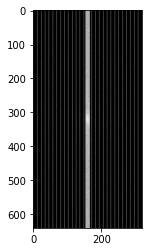

In [9]:
plt.imshow(np.log(np.abs(test_slice_kspace) + 1e-9), cmap = 'gray')


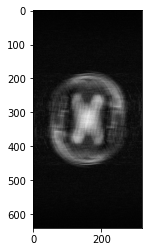

In [10]:
# Reconstruction for just this single-coil k-space
plt.imshow(test_slice_image, cmap = 'gray')


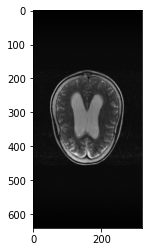

In [11]:
plt.imshow(test_target_slice_image,cmap='gray')


In [12]:
# Make prediction with our model

reconstructed_test_image = model.predict([X_test, grappa_test_indx])



In [10]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(test_target_slice_image,reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


0.41996166


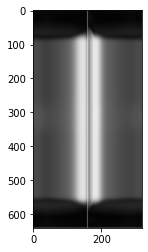

In [18]:
# Result of reconstruction of a FLAIR test scan using the model weights from epoch 1
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


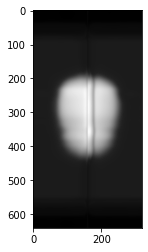

In [11]:
# Result of reconstruction of a FLAIR test scan using the model weights from epoch 8
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


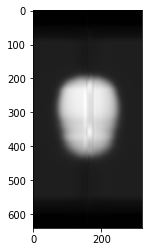

In [11]:
# Result of reconstruction of a FLAIR test scan using the model weights from epoch 15
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


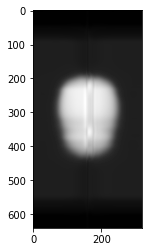

In [14]:
# Result of reconstruction of a T2 test scan using the model weights from epoch 15
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [ ]:
# Load a seen training scan

from utils import calculate_mask

train_path = os.path.join(download_path,'multicoil_train')

file_name = 'file_brain_AXFLAIR_200_6002493.h5'

hf_train = h5py.File(os.path.join(train_path, file_name))

train_volume_kspace = hf_train['kspace'][()]

nSL, nCh, nFE, nPE = train_volume_kspace.shape

X_train = []
Y_train = []
grappa_wt = []
grappa_p = []

mask = calculate_mask(nFE,nPE,0.08,4)
subsampled_k = train_volume_kspace*mask

for slice in range(nSL): 
    target_img = np.zeros((nCh,nFE,nPE),dtype=np.float)
    sub_kspace = np.zeros((nCh*2,nFE,nPE),dtype=np.float)
    wt,ps = estimate_mdgrappa_kernel(kspace=subsampled_k[slice,:,:,:],calib=None,kernel_size=(5,5),coil_axis=0) 
    for iCh in range(nCh):
            target_img[iCh,:,:] = abs(fft.fftshift(fft.ifft2(train_volume_kspace[slice,iCh,:,:])))
            sub_kspace[iCh,:,:] = subsampled_k[slice,iCh,:,:].real
            sub_kspace[iCh+nCh,:,:] = subsampled_k[slice,iCh,:,:].imag
    X_train.append(list(sub_kspace))
    Y_train.append(list(target_img))
    grappa_wt.append(wt)
    grappa_p.append(ps)

X_train = np.transpose(X_train,(0,2,3,1))
Y_train_rss = np.sqrt(np.sum(np.square(Y_train),axis=1))
Y_train_rss = Y_train_rss.astype(np.float32)

dims = X_train.shape
for i in range(dims[0]):
    for j in range(dims[3]):
        X_train[i,:,:,j] = X_train[i,:,:,j]/((np.max(X_train[i,:,:,j])-np.min(X_train[i,:,:,j]))+1e-10)

for i in range(dims[0]):
    Y_train_rss[i,:,:] = Y_train_rss[i,:,:]/((np.max(Y_train_rss[i,:,:])-np.min(Y_train_rss[i,:,:]))+1e-10)

grappa_train_indx = np.array(range(0,X_train.shape[0]),dtype=int)

In [23]:
# Select a slice to predict
slice = 3
coil = 0

train_slice_kspace = X_train[slice,:,:,coil]
train_slice_image = abs(fft.fftshift(fft.ifft2(train_slice_kspace)))
train_target_slice_image = Y_train_rss[slice,:,:]

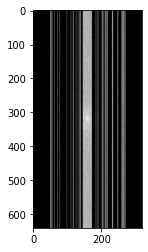

In [24]:
plt.imshow(np.log(np.abs(train_slice_kspace) + 1e-9), cmap = 'gray')


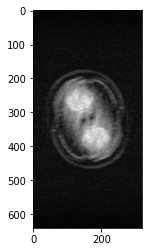

In [25]:
# Reconstruction for just this single-coil k-space
plt.imshow(train_slice_image, cmap = 'gray')


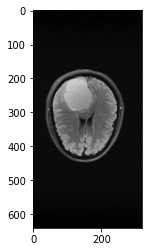

In [26]:
plt.imshow(train_target_slice_image,cmap='gray')


In [31]:
# Make prediction with our model

reconstructed_train_image = model.predict([X_train, grappa_train_indx])


In [32]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(train_target_slice_image,reconstructed_train_image[slice,:,:])
print(nmse_reconstruction)


0.39396352


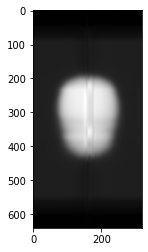

In [33]:
# Result of reconstruction of a training scan using the model weights from epoch 15
plt.imshow(reconstructed_train_image[slice,:,:], cmap='gray')


In [ ]:
# Try directly loading a sample from the 70 processed training files?
# Then we can take away the variance caused by the mask in the preprocessing


In [5]:
import pickle

path_of_saved_mri_data = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Preprocessing/fully_processed_at_once/'
path_of_saved_grappa_data = path_of_saved_mri_data

X_train = np.load(path_of_saved_mri_data+"training_data_GrappaNet_16_coils.npy")
Y_train = np.load(path_of_saved_mri_data+"training_data_GT_GrappaNet_16_coils.npy")

with open(path_of_saved_grappa_data+'grappa_wt.pickle', 'rb') as handle:
    grappa_wt = pickle.load(handle)

with open(path_of_saved_grappa_data+'grappa_p.pickle', 'rb') as handle:
    grappa_p = pickle.load(handle)

X_train = np.transpose(X_train,(0,2,3,1))
Y_rss = np.sqrt(np.sum(np.square(Y_train),axis=1))
Y_rss = Y_rss.astype(np.float32)

dims = X_train.shape
for i in range(dims[0]):
    for j in range(dims[3]):
        X_train[i,:,:,j] = X_train[i,:,:,j]/((np.max(X_train[i,:,:,j])-np.min(X_train[i,:,:,j]))+1e-10)

for i in range(dims[0]):
    Y_rss[i,:,:] = Y_rss[i,:,:]/((np.max(Y_rss[i,:,:])-np.min(Y_rss[i,:,:]))+1e-10)

x_train = X_train[0:int(X_train.shape[0]-X_train.shape[0]*0.1),:,:,:]
y_train = Y_rss[0:int(X_train.shape[0]-X_train.shape[0]*0.1),:,:]
x_test = X_train[int(X_train.shape[0]-X_train.shape[0]*0.1):,:,:,:]
y_test = Y_rss[int(X_train.shape[0]-X_train.shape[0]*0.1):,:,:]
y_test = np.reshape(y_test, (y_test.shape[0],crop_size[1],crop_size[2]))
grappa_train_indx = np.array(range(0,int(X_train.shape[0]-X_train.shape[0]*0.1)),dtype=int)
grappa_test_indx = np.array(range(int(X_train.shape[0]-X_train.shape[0]*0.1),X_train.shape[0]),dtype=int)



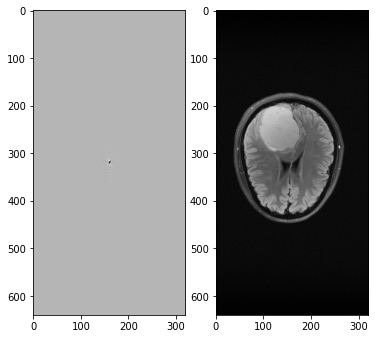

In [6]:
indx = 3
ref_img = abs(fft.fftshift(fft.ifft2(x_train[indx,:,:,:])))

fix,ax = plt.subplots(nrows=1,ncols=2,figsize=(6,10))
ax[0].imshow(x_train[indx,:,:,0],cmap='gray')
ax[1].imshow(Y_rss[indx,:,:],cmap='gray')

plt.show()


In [7]:
# Make prediction with our model

reconstructed_train_image = model.predict([x_train, grappa_train_indx])


In [8]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(y_train[indx,:,:],reconstructed_train_image[indx,:,:])
print(nmse_reconstruction)


0.3938359


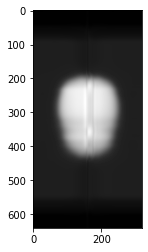

In [11]:
plt.imshow(reconstructed_train_image[indx,:,:], cmap='gray')
